**Условие**

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

**Входные данные**

В качестве входных данных есть 4 csv-файла:

- groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
import requests 
from urllib.parse import urlencode 

Сначала подгрузим все данные и изучим их: посмотрим, как выглядят данные, каких они типов, сколько строк с пропущенными значениями.

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key_1 = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
public_key_2 = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
public_key_3 = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
public_key_4 = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

#groups
final_url_1 = base_url + urlencode(dict(public_key=public_key_1)) 
response_1 = requests.get(final_url_1) 
url_1 = response_1.json()['href'] 
groups = pd.read_csv(url_1, sep = ';')

#group_add
final_url_2 = base_url + urlencode(dict(public_key=public_key_2)) 
response_2 = requests.get(final_url_2) 
url_2 = response_2.json()['href'] 
group_add = pd.read_csv(url_2, sep=',')

#active_studs
final_url_3 = base_url + urlencode(dict(public_key=public_key_3)) 
response_3 = requests.get(final_url_3) 
url_3 = response_3.json()['href'] 
active_studs = pd.read_csv(url_3, sep=';')

#checks
final_url_4 = base_url + urlencode(dict(public_key=public_key_4)) 
response_4 = requests.get(final_url_4) 
url_4 = response_4.json()['href'] 
checks = pd.read_csv(url_4, sep=';')

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [5]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [6]:
group_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [7]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [8]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [9]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [10]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


Ни в одном датафрейме нет пропущенных значений.

Приступим к объединению всех датафреймов в один. Для начала нужно соединить основной файл groups с информацией по группам и дополнительный файл groups_add. Сделаем это с помощью pd.concat.

In [11]:
groups_full = pd.concat([groups, group_add])
groups_full.info()
#проверим себя: количество строк должно быть 74484 + 92 = 74576

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


Чтобы добавить информацию датафрейма active_studs, создадим отдельный столбец, куда запишем 1, если студент был активным пользователем в дни эксперимента, и 0, если нет.

In [12]:
groups_full['is_active_stud'] = np.where(groups_full['id']. isin (active_studs['student_id']), 1, 0)

Смерджим получившийся датафрейм с checks. Удалим столбец student_id.

In [13]:
groups_full = pd.merge(groups_full, checks, how = 'left', left_on = 'id', right_on = 'student_id')
groups_full.drop('student_id', axis = 1 , inplace = True) 

Посмотрим на получившийся датафрейм: сколько строк, сколько пропущенных значений.

In [14]:
groups_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 74575
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74576 non-null  int64  
 1   grp             74576 non-null  object 
 2   is_active_stud  74576 non-null  int64  
 3   rev             541 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.8+ MB


In [15]:
groups_full.isnull().sum()

id                    0
grp                   0
is_active_stud        0
rev               74035
dtype: int64

Можно мысленно предварительно разделить всех пользователей на 4 группы:
- кто был на сайте и сделал оплату
- кто не был на сайте и не сделал оплату
- кто был на сайте и не сделал оплату
- кто не был на сайте и сделал оплату 

Первые три группы типичны, а вот четвертая - нет. Проверим, есть ли в данных такие пользователи.

In [16]:
groups_full.query('rev.notnull() & is_active_stud == 0').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 39 to 74216
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              149 non-null    int64  
 1   grp             149 non-null    object 
 2   is_active_stud  149 non-null    int64  
 3   rev             149 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 5.8+ KB


Выделим таких пользователей в отдельный датафрейм error.


In [17]:
error = groups_full.query('rev.notnull() & is_active_stud == 0')
error.id

39          3185
121        25973
125        26280
223       100645
254       102534
          ...   
72452    5291900
72753    5331842
73632    5486319
74049    5562806
74216    5599663
Name: id, Length: 149, dtype: int64

Видим 149 неактивных пользователей, у которых была оплата в дни эксперимента. Это может означать две вещи:
- или у пользователей прошла автоматическая оплата (если мы предлагаем, например, оплату регулярной подписки),
- или если такая функция у нас недоступна, это может быть ошибка при записи лога (в этом случае можем подсветить проблему разработчикам).

Предположим, что у нас есть функция регулярной оплаты - а это значит, что 149 покупателя не видела новую систему оплаты и не подходят для нашего эксперимента. Уберем данные о них.

Также заменим все пропущенные значения в столбце rev на 0.

In [18]:
groups_full = groups_full[~groups_full['id'].isin(error['id'])].fillna(0)

In [19]:
groups_full.head()

,id,grp,is_active_stud,rev
0,1489,B,0,0.0
1,1627,A,1,990.0
2,1768,B,0,0.0
3,1783,B,0,0.0
4,1794,A,0,0.0


## Выбор метрик и проведение статистических тестов

Выберем несколько метрик, на которые могла повлиять новая механика оплаты:
1. ARPPU (средний доход на покупателя)
2. ARPAU (средний доход на активного пользователя)
3. CR_ACTIVE (коэффициент конверсии активного пользователя в покупателя)

### 1. ARPPU

ARPPU = Доход от всех покупателей / Количество всех покупателей

In [20]:
ARPPU = groups_full.query('rev != 0').groupby('grp').agg({'rev': 'sum', 'id': 'nunique'})
ARPPU['ARPAU'] = ARPPU['rev'] / ARPPU['id']
ARPPU

,rev,id,ARPAU
grp,,,
A,72820.0000,78,933.589744
B,394974.0035,314,1257.878992


На первый взгляд средний доход на платящего пользователя подрос. Сформулируем гипотезы и проведем статистические тесты.

Гипотезы:
- H0 - средний доход на платящего пользователя не изменился
- H1 - средний доход на платящего пользователя изменился

In [21]:
rev_paying_a = groups_full.query('grp == "A" & rev != 0').rev
rev_paying_b = groups_full.query('grp == "B" & rev != 0').rev

Группы достаточно большие, у нас две группы и непрерывная величина. Проверим распределения на нормальность и гомоскедастичность.

- Нормальность

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


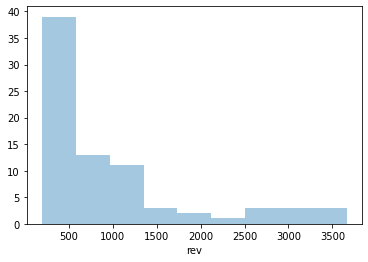

In [22]:
sns.distplot(rev_paying_a, hist=True, kde=False)

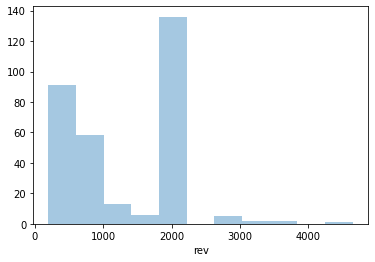

In [23]:
sns.distplot(rev_paying_b, hist=True, kde=False)

In [24]:
stat_arppu_a, pval_arppu_a = ss.normaltest(rev_paying_a)
stat_arppu_b, pval_arppu_b = ss.normaltest(rev_paying_b)
print(f'Значения p-value распределения группы A - {pval_arppu_a}, группы B - {pval_arppu_b}.')

Значения p-value распределения группы A - 2.5316868804220266e-07, группы B - 0.033445723194625424.


Оба распределения явно не являются нормальными - это и видно на графиках, и подтверждают расчеты (p-value для обоих распределений меньше 0.05).

- Гомоскедастичность

In [25]:
ss.levene(rev_paying_a, rev_paying_b)

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

p-value > 0.05, значит, дисперсии однородны.

Несмотря на то, что распределения не являются нормальными, дисперсии однородны, а группы достаточно большие, поэтому используем t-тест.

In [26]:
ss.ttest_ind(rev_paying_a, rev_paying_b)

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

p-value < 0.05, значит, отклоняем нулевую гипотезу о том, что средний чек покупателя не изменился. Разница является статистически значимой.

### 2. ARPAU

ARPAU = Доход от всех активных пользователей / Количество всех активных пользователей

Активным пользователем назовем такого пользователя, который во время эксперимента заходил на платформу.

In [27]:
ARPAU = groups_full.query('is_active_stud == 1').groupby('grp').agg({'rev': 'sum', 'id': 'nunique'})
ARPAU['ARPAU'] = ARPAU['rev'] / ARPAU['id']
ARPAU

,rev,id,ARPAU
grp,,,
A,72820.0000,1538,47.347204
B,394974.0035,6803,58.058798


ARPAU тоже у второй группы выше, чем у первой. Проверим, является ли эта разница статистически значимой.

Гипотезы:
- H0 - средний оход на активного пользователя не изменился
- H1 - средний оход на активного пользователя изменился

In [28]:
rev_active_a = groups_full.query('grp == "A" & is_active_stud == 1').rev
rev_active_b = groups_full.query('grp == "B" & is_active_stud == 1').rev

- Нормальность

In [29]:
stat_arpau_a, pval_arpau_a = ss.normaltest(rev_active_a)
stat_arpau_b, pval_arpau_b = ss.normaltest(rev_active_b)
print(f'Значения p-value распределения группы A - {pval_arpau_a}, группы B - {pval_arpau_b}.')

Значения p-value распределения группы A - 0.0, группы B - 0.0.


Оба распределения не являются нормальными.

- Гомоскедастичность

In [30]:
ss.levene(rev_active_a, rev_active_b)

LeveneResult(statistic=1.501460829433639, pvalue=0.22048133327049665)

p-value > 0.05, значит, дисперсии однородны.

Аналогично с предыдущим пунктом используем t-тест.

In [31]:
ss.ttest_ind(rev_active_a, rev_active_b)

Ttest_indResult(statistic=-1.2253411073793445, pvalue=0.22048133326988378)

p-value > 0.05, а значит, мы не имеем оснований отклоний нулевую гипотезу, и разница ARPAU двух групп не является статистически значимой.

### 3. CR_ACTIVE
Коэффициент_конверсии_активный_покупатель = (Число покупателей / Число активных пользователей) * 100

In [32]:
groups_full.query('is_active_stud == 1').groupby('grp').id.count()

grp
A    1538
B    6803
Name: id, dtype: int64

In [33]:
groups_full.query('rev != 0').groupby('grp').rev.count()

grp
A     78
B    314
Name: rev, dtype: int64

In [34]:
conversion_active_buyer = (groups_full.query('rev != 0').groupby('grp').rev.count() / groups_full.query('is_active_stud == 1').groupby('grp').id.count())*100
conversion_active_buyer.reset_index()

,grp,0
0,A,5.071521
1,B,4.615611


Видим, что конверсия активного пользователя в покупателя немного упала. Проверим, является, ли эта разница статистически значимой.

Гипотезы:
- H0 - конверсия активного пользователя в покупателя не изменилась
- H1 - конверсия активного пользователя в покупателя изменилась

Для расчета конверсии можем использовать хи-квадрат.

In [35]:
crosstab = pd.crosstab(groups_full['grp'], groups_full['rev'], normalize='index')
crosstab

rev,0.0,199.0,290.0,398.0,489.0,580.0,590.0,597.0,690.0,796.0,...,2190.0,2220.0,2820.0,2890.0,2900.0,2910.0,3040.0,3260.0,3660.0,4650.0
grp,,,,,,,,,,,,,,,,,,,,,
A,0.994681,0.000341,0.001705,0.000068,0.000136,0.000409,0.000341,0.000000,0.000273,0.000000,...,0.000000,0.000068,0.000136,0.000068,0.000068,0.000136,0.000000,0.000000,0.000205,0.000000
B,0.994746,0.000452,0.000753,0.000100,0.000017,0.000084,0.000100,0.000017,0.000218,0.000017,...,0.000017,0.000017,0.000000,0.000050,0.000000,0.000033,0.000017,0.000017,0.000033,0.000017


In [36]:
conversion_active_buyer_a = np.array([groups_full.query('is_active_stud == 1 & grp == "A"').groupby('grp').id.count(), 
                                    groups_full.query('grp == "A"').groupby('grp').rev.count()])
conversion_active_buyer_b = np.array([groups_full.query('is_active_stud == 1 & grp == "B"').groupby('grp').id.count(), 
                                    groups_full.query('grp == "B"').groupby('grp').rev.count()])

In [37]:
chi2, p, dof, ex = ss.chi2_contingency([conversion_active_buyer_a, conversion_active_buyer_b], correction=False)
print(f'p-value = {p}')

p-value = 0.005818674190793832


p-value > 0.05, значит, не отклоняем нулевую гипотезу - разница не является статистически значимой, то есть новая механика оплаты услуг на сайте не повлияла на конверсию активного пользователя в покупателя.

Посмотрим еще раз на все метрики.

In [38]:
arppu_a = groups_full.query('rev != 0 & grp == "A"').rev.sum() / groups_full.query('rev != 0 & grp == "A"').id.count()
arppu_b = groups_full.query('rev != 0 & grp == "B"').rev.sum() / groups_full.query('rev != 0 & grp == "B"').id.count()
    
arpau_a = groups_full.query('is_active_stud == 1 & grp == "A"').rev.sum() / groups_full.query('is_active_stud == 1 & grp == "A"').id.count()
arpau_b = groups_full.query('is_active_stud == 1 & grp == "B"').rev.sum() / groups_full.query('is_active_stud == 1 & grp == "B"').id.count()
    
cr_active_a = (groups_full.query('rev != 0 & grp == "A"').rev.count() / groups_full.query('is_active_stud == 1 & grp == "A"').id.count())*100
cr_active_b = (groups_full.query('rev != 0 & grp == "B"').rev.count() / groups_full.query('is_active_stud == 1 & grp == "B"').id.count())*100
    
metrics = pd.DataFrame({'grp': ['A', 'B'], 
                        'ARPPU': [arppu_a, arppu_b], 
                        'ARPAU': [arpau_a, arpau_b], 
                        'CR_ACTIVE': [cr_active_a, cr_active_b]})
metrics

,grp,ARPPU,ARPAU,CR_ACTIVE
0,A,933.589744,47.347204,5.071521
1,B,1257.878992,58.058798,4.615611


# Вывод

Результаты тестирования очень противоречивы. В целом состояние бизнеса мы не ухудшили, но при этом и не получили никаких хороших результатов.

С одной стороны вырос средний доход на покупателя, но с другой стороны мы не получили статистически значимой разницы в среднем доходе на активного пользователя и конверсии активного пользователя в покупателя.

Тот факт, что вырос показатель ARPPU и не изменились все остальные метрики (в частности - конверсия активных пользователей в покупателей), может означать, что пользователи просто покупали более дорогие товары, и на это вряд ли могла повлиять новая система оплаты.

Вывод: раскатывать новую систему оплаты на всех пользователей пока рано. Нужно либо дорабатывать саму систему и четко понимать, на какие метрики она должна повлиять и как, либо проводить дополнительные тесты.